<img src="https://pandas.pydata.org/static/img/pandas.svg"
     width="30%"/>
<img src="https://docs.dask.org/en/stable/_images/dask_horizontal.svg"
     width="30%"/>

Cloud Parquet ETL with Dask DataFrame
=====================================

| Data           | Cost  |
|:---------------|:------|
| 100 GB Parquet | $0.10 |

This notebook looks at every [Uber and Lyft ride in New York City](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) over the last several years.  Because the data is large, we operate on a cluster in the cloud.

You can {download}`download this Jupyter notebook <uber-lyft.ipynb>` to follow along.

## Install Dask and Coiled

This example requires the packages `dask s3fs matplotlib coiled`.  We do this in a new virtual environment below, but you could also install them in whatever environment you’re already using.

```
conda create -n coiled-nyc -c conda-forge python=3.11 coiled dask s3fs matplotlib
conda activate coiled-nyc
```

You also could use `pip` for everything, or any other package manager you prefer. `conda` isn’t required.

When you later create a Coiled cluster, your local `coiled-nyc` environment will be automatically replicated on your cluster.

## Create Dask cluster in the cloud

This dataset is ~100 GB in size, and so is too large for a typical laptop.  We use Coiled to create a Dask cluster that's big enough to handle our data comfortably.

In [ ]:
import coiled

cluster = coiled.Cluster(
    n_workers=30,
    region="us-east-2",  # Start workers in same region as data to minimize costs
)

client = cluster.get_client()

This is the only Coiled-specific code. The remainder of this example is normal Dask code that would look the same for any Dask deployment.

## Load and prepare data

Let's look at our data using Dask DataFrame's [`read_parquet`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_parquet.html#dask.dataframe.read_parquet) function to load our dataset from S3. 

In [2]:
import dask.dataframe as dd

df = dd.read_parquet("s3://coiled-data/uber/")
df.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B02867               B02867   
1            HV0003               B02879               B02879   
2            HV0005               B02510                 <NA>   
3            HV0005               B02510                 <NA>   
4            HV0005               B02510                 <NA>   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2019-02-01 00:01:26 2019-02-01 00:02:55 2019-02-01 00:05:18   
1 2019-02-01 00:26:08 2019-02-01 00:41:29 2019-02-01 00:41:29   
2 2019-02-01 00:48:58                 NaT 2019-02-01 00:51:34   
3 2019-02-01 00:02:15                 NaT 2019-02-01 00:03:51   
4 2019-02-01 00:06:17                 NaT 2019-02-01 00:09:44   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  sales_tax  \
0 2019-02-01 00:14:57           245           251        2.45  ...       0.83   
1 2019-02-01 00:49:39           216           197        1.71  ...       0.70   
2 2019-02-01 01:28:29           261           234        5.01  ...       3.99   
3 2019-02-01 00:07:16            87            87        0.34  ...       0.64   
4 2019-02-01 00:39:56            87           198        6.84  ...       2.16   

   congestion_surcharge  airport_fee  tips  driver_pay  shared_request_flag  \
0                   0.0          NaN   0.0    7.480000                    Y   
1                   0.0          NaN   2.0    7.930000                    N   
2                   0.0          NaN   0.0   35.970001                    N   
3                   0.0          NaN   3.0    5.390000                    N   
4                   0.0          NaN   4.0   17.070000                    N   

   shared_match_flag  access_a_ride_flag  wav_request_flag wav_match_flag  
0                  N                   N                 N            NaN  
1                  N                   N                 N            NaN  
2                  Y                   N                 N            NaN  
3                  Y                   N                 N            NaN  
4                  Y                   N                 N            NaN  

[5 rows x 24 columns]

In preparation for exploring this dataset, let's apply a few of feature engineering steps. Specifically:

- Create a new `tipped` column that indicates if a ride included a tip or not.
- Create a new `tip_frac` column for the tip amount relative to the overall cost of the ride.
- Replace the `hvfhs_license_num` column with a more familiar `service` column with names like `"uber"` instead of codes like `"HV0003"`.

In [3]:
df["tipped"] = df["tips"] != 0
df["tip_frac"] = df["tips"] / (df["base_passenger_fare"] + df["tolls"] + df["bcf"] + df["sales_tax"] + df["congestion_surcharge"].fillna(0) + df["airport_fee"].fillna(0))
df["service"] = df["hvfhs_license_num"].map({
    "HV0003": "uber",
    "HV0005": "lyft",
    "HV0002": "juno",
    "HV0004": "via",
})
df = df.drop(columns="hvfhs_license_num")
df.head()

dispatching_base_num originating_base_num    request_datetime  \
0               B02867               B02867 2019-02-01 00:01:26   
1               B02879               B02879 2019-02-01 00:26:08   
2               B02510                 <NA> 2019-02-01 00:48:58   
3               B02510                 <NA> 2019-02-01 00:02:15   
4               B02510                 <NA> 2019-02-01 00:06:17   

    on_scene_datetime     pickup_datetime    dropoff_datetime  PULocationID  \
0 2019-02-01 00:02:55 2019-02-01 00:05:18 2019-02-01 00:14:57           245   
1 2019-02-01 00:41:29 2019-02-01 00:41:29 2019-02-01 00:49:39           216   
2                 NaT 2019-02-01 00:51:34 2019-02-01 01:28:29           261   
3                 NaT 2019-02-01 00:03:51 2019-02-01 00:07:16            87   
4                 NaT 2019-02-01 00:09:44 2019-02-01 00:39:56            87   

   DOLocationID  trip_miles  trip_time  ...  tips  driver_pay  \
0           251        2.45        579  ...   0.0    7.480000   
1           197        1.71        490  ...   2.0    7.930000   
2           234        5.01       2159  ...   0.0   35.970001   
3            87        0.34        179  ...   3.0    5.390000   
4           198        6.84       1799  ...   4.0   17.070000   

   shared_request_flag  shared_match_flag  access_a_ride_flag  \
0                    Y                  N                   N   
1                    N                  N                   N   
2                    N                  Y                   N   
3                    N                  Y                   N   
4                    N                  Y                   N   

   wav_request_flag  wav_match_flag  tipped  tip_frac service  
0                 N             NaN   False  0.000000    uber  
1                 N             NaN    True  0.227015    uber  
2                 N             NaN   False  0.000000    lyft  
3                 N             NaN    True  0.374532    lyft  
4                 N             NaN    True  0.147438    lyft  

[5 rows x 26 columns]

We're now ready to explore this dataset in more detail.

## Explore

Let's analyze our dataset to answer a few questions about tipping practices and driver pay.

As a first step, let's load the dataset into our cluster's distributed memory using `df.persist()`.
This loads and caches the dataset on the cluster, allowing us to avoid repeated expensive data loading steps when doing multiple computations on the same dataset. 

In [4]:
df = df.persist()

### Tipping frequency

How often do New Yorkers tip?

In [5]:
df["tipped"].mean().compute()

0.15895858700806212

About 16% of the time.

### Broken down by carrier

Do ride-share services get tipped at different rates?

In [6]:
df.groupby("service").tipped.mean().compute()

service
juno    0.084400
lyft    0.191230
uber    0.149856
via     0.092949
Name: tipped, dtype: float64

Lyft riders tip more often at a frequency of 19% than Uber riders at 15%.

### Tipping amount

Do riders of different services tip different amounts? 

In [7]:
df = df.set_index("pickup_datetime").persist()

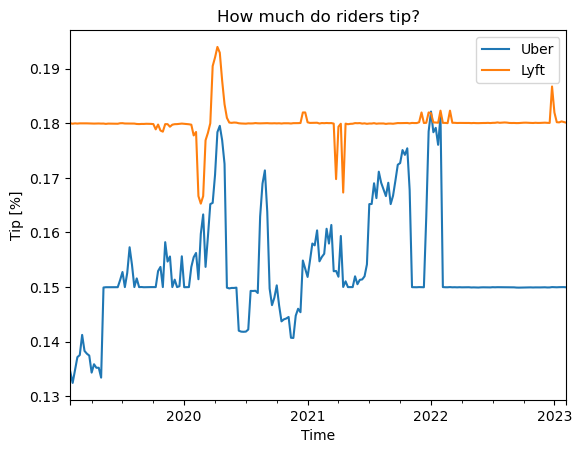

In [8]:
import matplotlib.pyplot as plt

ax = plt.subplot()
df2 = df.loc[df["tipped"]]
df2.loc[df2["service"] == "uber", "tip_frac"].resample("1w").median().compute().plot(ax=ax)
df2.loc[df2["service"] == "lyft", "tip_frac"].resample("1w").median().compute().plot(ax=ax)
plt.legend(["Uber", "Lyft"])
plt.title("How much do riders tip?")
plt.xlabel("Time")
plt.ylabel("Tip [%]");

We can see Lyft rider tip relatively consistently at ~18%, while Uber rider's tip amount is more volatile and generally less than Lyft riders. 

### Driver Pay

Let's also take a look at how much drivers make relative to how much passengers pay.

In [9]:
df.base_passenger_fare.sum().compute()

15818734000.0

In [10]:
df.driver_pay.sum().compute()

12794474000.0

Riders spent about `$`16 Billion over the range of the dataset, and Drivers took home almost all of that (about `$`13 Billion).  Let's see how that tracks over time.

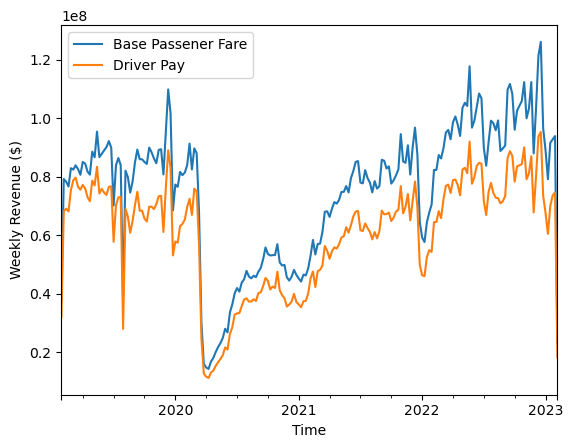

In [11]:
import matplotlib.pyplot as plt

ax = plt.subplot()
df.base_passenger_fare.resample("1w").sum().compute().plot(ax=ax)
df.driver_pay.resample("1w").sum().compute().plot(ax=ax)
plt.legend(["Base Passener Fare", "Driver Pay"])
plt.xlabel("Time")
plt.ylabel("Weekly Revenue ($)");

We see some big events, like the massive drop in ridership during COVID-19 and a smaller drop when the Omicron variant was first detected, along with an eventual recovery to greater-than-pre-COVID levels.

We can also see how, ever since the financial outlook of Uber/Lyft style companies has become a bit less friendly, they've started to ask for a larger share of revenue from their rides.  

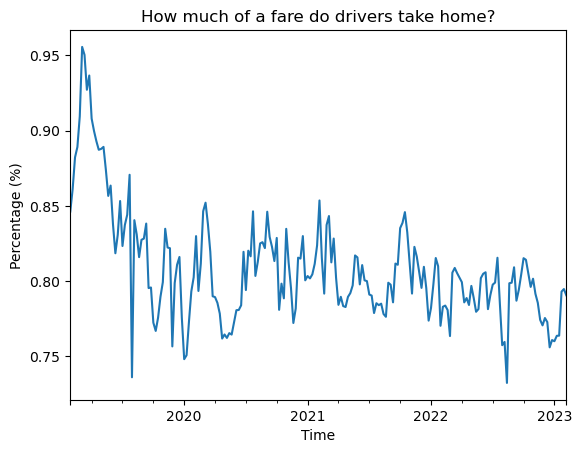

In [12]:
(df.driver_pay.resample("1w").sum() / df.base_passenger_fare.resample("1w").sum()).compute().plot()

plt.title("How much of a fare do drivers take home?")
plt.xlabel("Time")
plt.ylabel("Percentage (%)");

### What's next?

The Uber/Lyft Rides dataset is complex and rich. What other questions do you want to answer?

## Conclusion

Dask DataFrame makes it easy to analyze a larger-than-memory cloud dataset using the familiar `pandas` API. Coiled makes it easy to scale up computing resources by creating large Dask clusters on the cloud with just a few lines of code.

If you have a cloud account it's easy to try this out yourself.  The data is public and this computation costs less than $0.10 in AWS cloud costs.  You can [sign up under the Coiled free tier here](https://coiled.io/start) (setup takes a couple minutes).